# Libraries

In [55]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import shapiro, normaltest, anderson
from scipy.stats import kurtosis

# Load Data

In [56]:
filepath = "../data/"

train_df = pd.read_parquet(filepath+"train.parquet")
# test_df = pd.read_parquet(filepath+"test.parquet")

In [57]:
print("Missing values in 'label':", train_df['label'].isna().sum())

if isinstance(train_df.index, pd.DatetimeIndex):
    is_sorted = train_df.index.is_monotonic_increasing
    is_unique = train_df.index.is_unique
    print(f"Index is datetime: True | Sorted: {is_sorted} | Unique: {is_unique}")
else:
    print("Index is not a DatetimeIndex.")

Missing values in 'label': 0
Index is datetime: True | Sorted: True | Unique: True


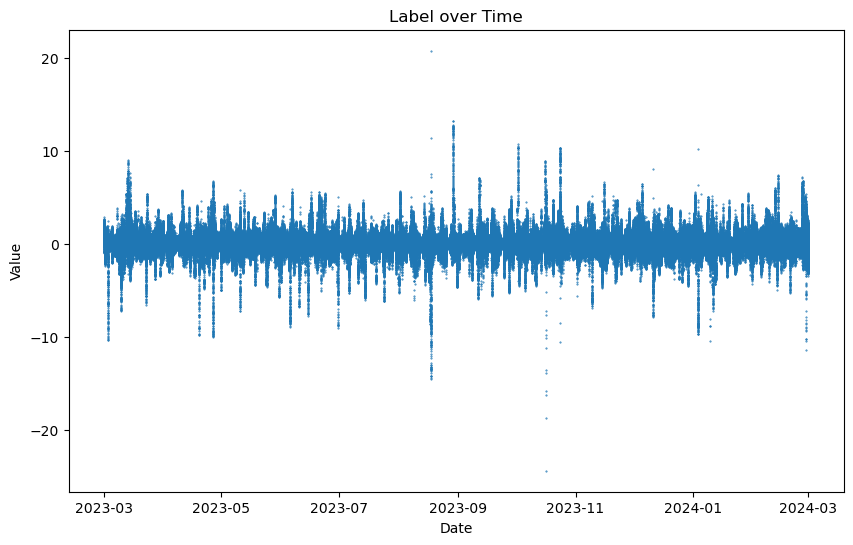

In [58]:
plt.figure(figsize=(10, 6))

plt.scatter(x=train_df.index, y=train_df['label'], s=0.2)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Label over Time')

plt.show()

# Target Distribution Analysis

## Descriptive Statistics  
- The target variable is relatively centered around zero, with a mean of **0.03**, indicating low bias prior to standardization. However, the standard deviation of approximately **1.0** reflects substantial dispersion.  
- This contrast is especially apparent when compared to the **narrow 95% confidence interval for the mean**, indicating that the overall distribution must be highly variable.  
- The **minimum and maximum values of -24 and 20**, respectively, further underscore the presence of extreme values and heavy tails. This pattern is consistent with a distribution closer to a **Student's t** or even **Cauchy**, rather than a standard Gaussian.

In [59]:
mean = train_df['label'].mean()
median = train_df['label'].median()
skew = train_df['label'].skew()
std = train_df['label'].std()

print(f"Target Mean: {mean}")
print(f"Target Median: {median}")
print(f"Target Standard Deviation: {std}")
print(f"Target Skew: {skew}")

z = 1.96  # or use t-score if n is small
stderr = std / np.sqrt(len(train_df))
ci_lower = mean - z * stderr
ci_upper = mean + z * stderr

print(f"95% CI for Mean (Assuming Normality): [{ci_lower:.4f}, {ci_upper:.4f}]")

train_df['label'].describe()

Target Mean: 0.03612583479917426
Target Median: 0.016260691207415537
Target Standard Deviation: 1.0099145156502942
Target Skew: -0.11348704299677286
95% CI for Mean (Assuming Normality): [0.0334, 0.0389]


count    525886.000000
mean          0.036126
std           1.009915
min         -24.416615
25%          -0.381586
50%           0.016261
75%           0.434137
max          20.740270
Name: label, dtype: float64

## Initial Plots  
- The boxplots, histograms, and KDE plots reflect the same key trends observed in the descriptive statistics: a strong concentration of values around **0** and the **mean**, but with a significant number of extreme outliers.  
- Even in the **clipped plots**, we see that the measures of dispersion (e.g., mean, median, standard deviation) remain tightly clustered near the center, reinforcing the idea of a central tendency surrounded by heavy tails.  
- The histogram and KDE also suggest **non-normality**, with tails that extend far beyond what would be expected under a Gaussian distribution—consistent with the earlier observation that the data may be better modeled by a **heavy-tailed distribution**.

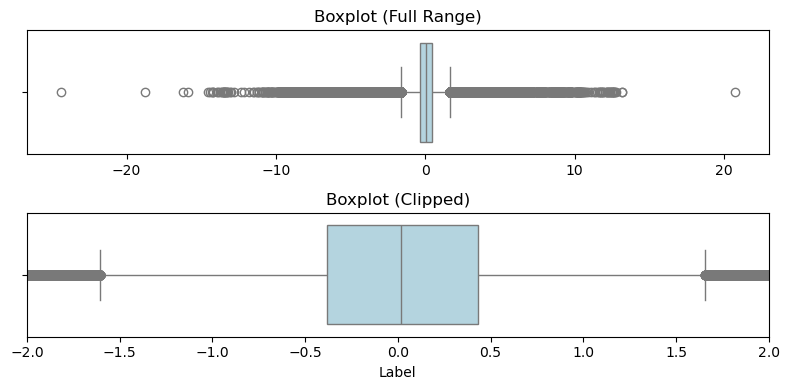

In [60]:
plt.figure(figsize=(8, 4))

plt.subplot(2, 1, 1)
sns.boxplot(x=train_df['label'], color='lightblue')
plt.title("Boxplot (Full Range)")
plt.xlabel("")

plt.subplot(2, 1, 2)
sns.boxplot(x=train_df['label'], color='lightblue')
plt.xlim(-2, 2)
plt.title("Boxplot (Clipped)")
plt.xlabel("Label")

plt.tight_layout()
plt.show()


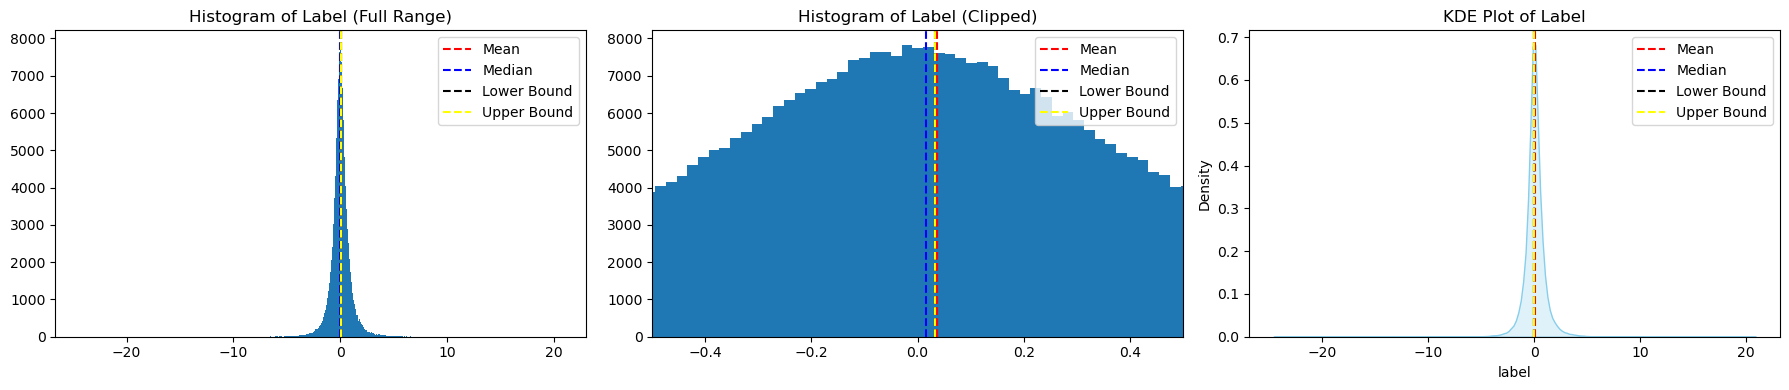

In [61]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

axes[0].hist(train_df['label'], bins='auto')
axes[0].axvline(x=mean, color='red', linestyle='--', label='Mean')
axes[0].axvline(x=median, color='blue', linestyle='--', label='Median')
axes[0].axvline(x=ci_lower, color='black', linestyle='--', label='Lower Bound')
axes[0].axvline(x=ci_lower, color='yellow', linestyle='--', label='Upper Bound')
axes[0].set_title("Histogram of Label (Full Range)")
axes[0].legend()

axes[1].hist(train_df['label'], bins='auto')
axes[1].axvline(x=mean, color='red', linestyle='--', label='Mean')
axes[1].axvline(x=median, color='blue', linestyle='--', label='Median')
axes[1].axvline(x=ci_lower, color='black', linestyle='--', label='Lower Bound')
axes[1].axvline(x=ci_lower, color='yellow', linestyle='--', label='Upper Bound')
axes[1].set_xlim(-0.5, 0.5)
axes[1].set_title("Histogram of Label (Clipped)")
axes[1].legend()

sns.kdeplot(train_df['label'], ax=axes[2], fill=True, color='skyblue')
axes[2].axvline(x=mean, color='red', linestyle='--', label='Mean')
axes[2].axvline(x=median, color='blue', linestyle='--', label='Median')
axes[2].axvline(x=ci_lower, color='black', linestyle='--', label='Lower Bound')
axes[2].axvline(x=ci_lower, color='yellow', linestyle='--', label='Upper Bound')
axes[2].set_title("KDE Plot of Label")
axes[2].legend()

plt.tight_layout()
plt.show()

## Distribution Analysis

### Normality Analysis

- Formal normality tests (Shapiro-Wilk, D’Agostino’s K², and Anderson-Darling) yield p-values well above typical thresholds (e.g., 0.05). However, due to the extremely large sample size (~500,000), these results may not be reliable—the tests can become overly sensitive or inaccurate at this scale.
- Despite high p-values, visual evidence from the Q-Q plot strongly suggests **non-normality**. We observe heavy tails and slight skewness, consistent with the descriptive statistics and histograms.
- Taken together, these indicators point toward a **departure from Gaussian behavior**, likely driven by outliers, kurtosis, and potential skew. This may be suggesting a distribution more aligned with heavy-tailed families like the Student-t or Cauchy.

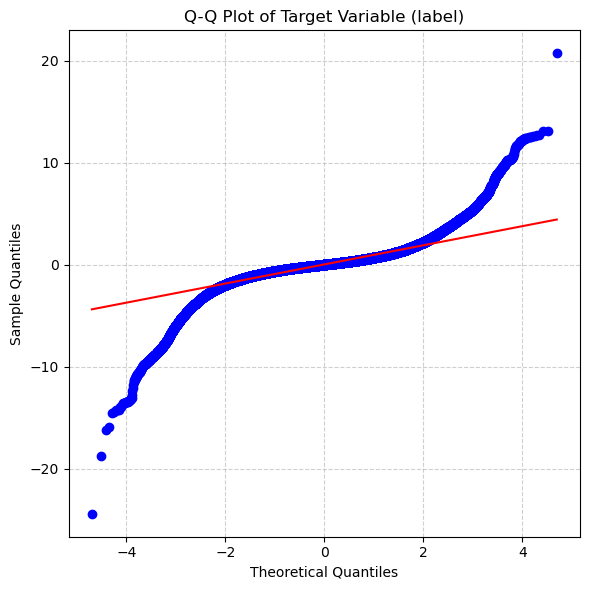

Kurtosis: 15.991546355483528
Skew: -0.11348704299677286
Shapiro-Wilk Test:      stat = 0.8627, p-value = 0.0000e+00
D’Agostino-Pearson Test: stat = 116907.3714, p-value = 0.0000e+00
Anderson-Darling Test:   stat = 14013.8673
  15% level: crit = 0.5760 → Reject H0
  10% level: crit = 0.6560 → Reject H0
  5% level: crit = 0.7870 → Reject H0
  2% level: crit = 0.9180 → Reject H0
  1% level: crit = 1.0920 → Reject H0


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [62]:
plt.figure(figsize=(6, 6))
stats.probplot(train_df['label'], dist="norm", plot=plt)

plt.title("Q-Q Plot of Target Variable (label)")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print("Kurtosis:", kurtosis(train_df['label']))
print("Skew:", skew)

shapiro_stat, shapiro_p = shapiro(train_df['label'])
print(f"Shapiro-Wilk Test:      stat = {shapiro_stat:.4f}, p-value = {shapiro_p:.4e}")
dagostino_stat, dagostino_p = normaltest(train_df['label'])
print(f"D’Agostino-Pearson Test: stat = {dagostino_stat:.4f}, p-value = {dagostino_p:.4e}")
anderson_result = anderson(train_df['label'], dist='norm')
print(f"Anderson-Darling Test:   stat = {anderson_result.statistic:.4f}")
for i in range(len(anderson_result.critical_values)):
    cv = anderson_result.critical_values[i]
    sl = anderson_result.significance_level[i]
    result = "Reject" if anderson_result.statistic > cv else "Fail to Reject"
    print(f"  {sl:.0f}% level: crit = {cv:.4f} → {result} H0")

### Distribution Testing

- The data exhibits pronounced heavy tails, prompting evaluation against heavy-tailed distributions.
- We tested the fit against Student’s t-distribution and Cauchy distribution using the Kolmogorov-Smirnov (K-S) test:
- The Student’s t-distribution provides a significantly better fit than the Cauchy distribution and also outperforms the normal distribution (tested separately).
- While the true underlying population may not be exactly t-distributed, this insight informs our modeling approach.
- Robust loss functions such as Huber loss, Tweedie loss, or quantile regression could improve model robustness to outliers.
- Alternatively, preprocessing methods like removing or down-weighting extreme outliers may be beneficial.
- Incorporating anomaly detection or scoring methods to identify extreme observations can further enhance predictive performance and robustness.

In [63]:
from scipy.stats import t, cauchy, kstest

data = train_df['label'].dropna().sort_values()
n = len(data)
ecdf = np.arange(1, n + 1) / n

t_params = t.fit(data)
cauchy_params = cauchy.fit(data)

cdf_t = t.cdf(data, *t_params)
cdf_cauchy = cauchy.cdf(data, *cauchy_params)

ks_t = kstest(data, 't', args=t_params)
ks_cauchy = kstest(data, 'cauchy', args=cauchy_params)

plt.figure(figsize=(10, 6))
plt.plot(data, ecdf, label='Empirical CDF', color='black', lw=2)

for name, cdf, ks in zip(
    ['t-distribution', 'Cauchy'],
    [cdf_t, cdf_cauchy],
    [ks_t, ks_cauchy]
):
    plt.plot(data, cdf, label=f"{name} CDF (D={ks.statistic:.4f})")
    plt.axvline(ks.statistic_location, linestyle=':', 
                label=f"{name} max dev @ {ks.statistic_location:.2f}")

plt.title('Empirical vs. Fitted CDFs for Different Heavy-Tailed Distributions')
plt.xlabel('Label Value')
plt.ylabel('CDF')
plt.legend()
plt.grid(True)
plt.show()

print("Kolmogorov-Smirnov test results:")
print(f"t-distribution:   D = {ks_t.statistic:.6f}, p = {ks_t.pvalue:.3e}")
print(f"Cauchy:          D = {ks_cauchy.statistic:.6f}, p = {ks_cauchy.pvalue:.3e}")

KeyboardInterrupt: 

# Regime Exploration

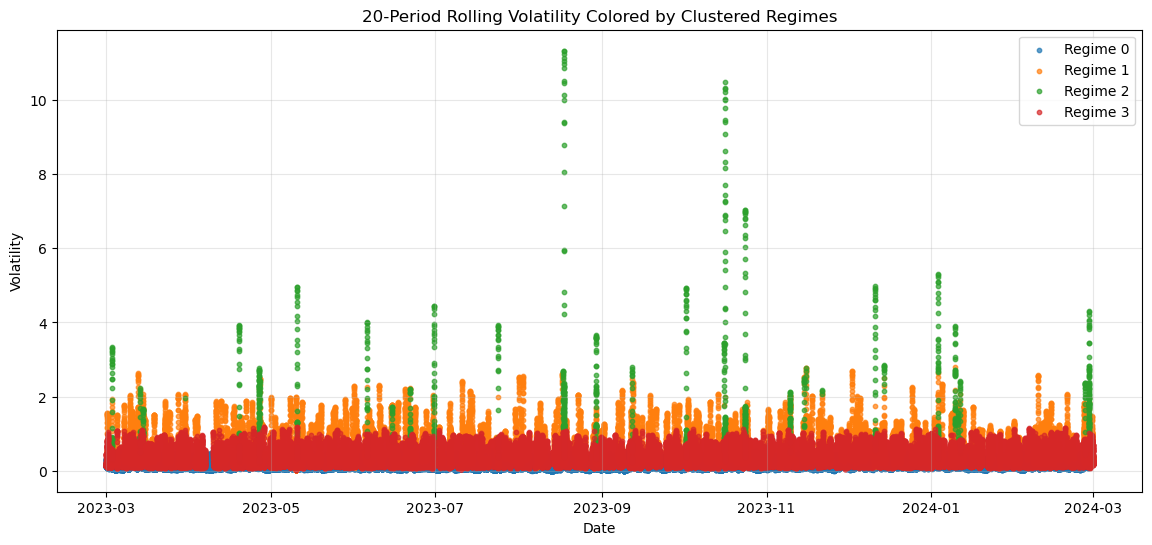

Volatility Regime Summary Statistics (multi-window clustering):

Regime 0:
Count: 334153
Mean: 0.01270
Std Dev: 0.55973
Skewness: 0.13962
Kurtosis: 2.03813

Regime 1:
Count: 33947
Mean: 0.07490
Std Dev: 2.30580
Skewness: -0.23546
Kurtosis: 4.55550

Regime 2:
Count: 1586
Mean: 0.05556
Std Dev: 2.87604
Skewness: -1.19345
Kurtosis: 8.73738

Regime 3:
Count: 156101
Mean: 0.07704
Std Dev: 1.23334
Skewness: 0.10069
Kurtosis: 1.75197


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Assume 'labels' is your returns series with datetime index and no NaNs

# Step 1: Calculate rolling volatilities for multiple windows
windows = [10, 20, 50, 100]
rolling_vols = pd.DataFrame({
    f'vol_{w}': labels.rolling(window=w).std()
    for w in windows
}).dropna()

# Step 2: Fit KMeans clustering to identify volatility regimes
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
rolling_vols['regime'] = kmeans.fit_predict(rolling_vols)

# Step 3: Plot rolling volatilities colored by regime
plt.figure(figsize=(14,6))
for regime in range(k):
    mask = rolling_vols['regime'] == regime
    plt.scatter(rolling_vols.index[mask], rolling_vols['vol_20'][mask],
                s=10, alpha=0.7, label=f'Regime {regime}')
plt.title('20-Period Rolling Volatility Colored by Clustered Regimes')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Step 4: Summary statistics per regime
print("Volatility Regime Summary Statistics (multi-window clustering):")
for regime in range(k):
    regime_data = labels.loc[rolling_vols.index][rolling_vols['regime'] == regime]
    print(f"\nRegime {regime}:")
    print(f"Count: {len(regime_data)}")
    print(f"Mean: {regime_data.mean():.5f}")
    print(f"Std Dev: {regime_data.std():.5f}")
    print(f"Skewness: {regime_data.skew():.5f}")
    print(f"Kurtosis: {regime_data.kurtosis():.5f}")


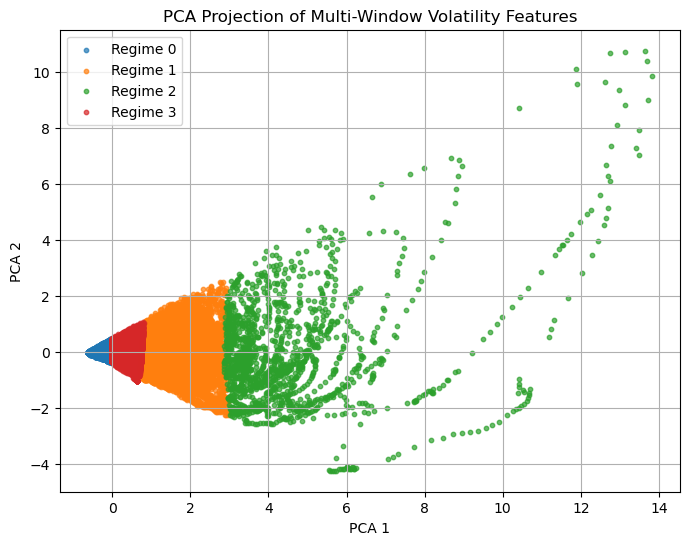

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

features = rolling_vols.drop(columns='regime')

pca = PCA(n_components=2)
components = pca.fit_transform(features)

plt.figure(figsize=(8,6))
for regime in range(k):
    idx = rolling_vols['regime'] == regime
    plt.scatter(components[idx,0], components[idx,1], s=10, alpha=0.7, label=f'Regime {regime}')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA Projection of Multi-Window Volatility Features')
plt.legend()
plt.grid(True)
plt.show()

from sklearn.metrics import silhouette_score

score = silhouette_score(features, rolling_vols['regime'])
print(f"Silhouette Score: {score:.4f}")

In [ ]:
from sklearn.metrics import silhouette_score

score = silhouette_score(features, rolling_vols['regime'])
print(f"Silhouette Score: {score:.4f}")

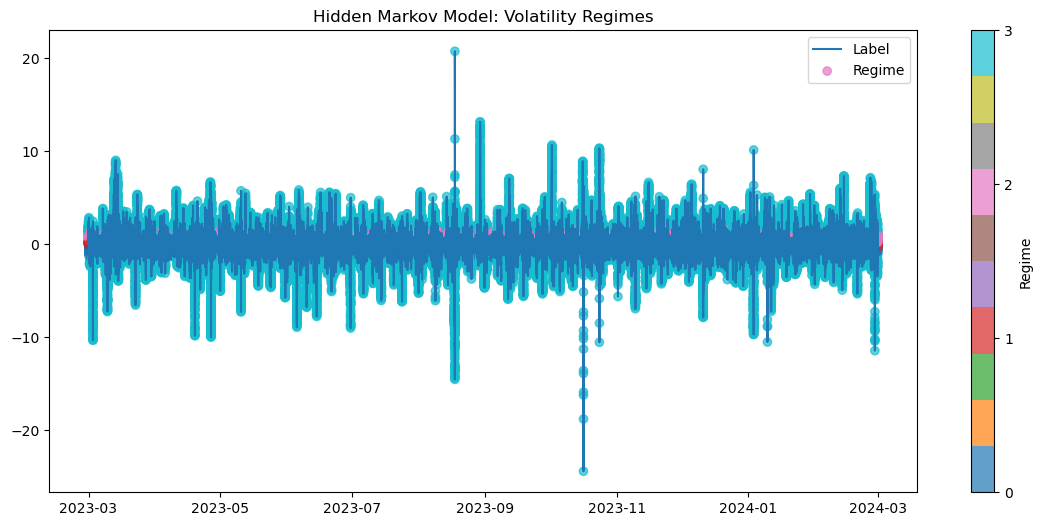

In [ ]:
from hmmlearn import hmm
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score


data = train_df['label'].dropna().values.reshape(-1,1)

# Fit HMM with 2 states (adjust if you want more)

model = hmm.GaussianHMM(n_components=4, covariance_type='full', n_iter=1000, random_state=42)
model.fit(data)

# Predict hidden states
states = model.predict(data)

# Plot label with state coloring
plt.figure(figsize=(14,6))
plt.plot(train_df.index[-len(states):], data.flatten(), label='Label')

scatter = plt.scatter(train_df.index[-len(states):], data.flatten(), c=states, cmap='tab10', label='Regime', alpha=0.7)
plt.colorbar(scatter, ticks=range(model.n_components), label='Regime')
plt.title('Hidden Markov Model: Volatility Regimes')
plt.legend()
plt.show()

states = model.predict(data)
df_states = pd.DataFrame({'label': data.flatten(), 'state': states})

state_summary = df_states.groupby('state')['label'].agg(['mean', 'std', 'count', 'min', 'max'])
print(state_summary)
print("Transition matrix:")
print(model.transmat_)

from scipy.stats import wasserstein_distance

states = model.predict(data)
df_states = pd.DataFrame({'label': data.flatten(), 'state': states})

# Compute pairwise Wasserstein distances between states
state_values = [df_states[df_states['state'] == s]['label'].values for s in df_states['state'].unique()]

for i in range(len(state_values)):
    for j in range(i+1, len(state_values)):
        dist = wasserstein_distance(state_values[i], state_values[j])
        print(f"Wasserstein distance between state {i} and {j}: {dist:.4f}")

sil_score = silhouette_score(data, states)
print(f"Silhouette Score for HMM states: {sil_score:.4f}")

In [ ]:
from scipy.stats import wasserstein_distance

states = model.predict(data)
df_states = pd.DataFrame({'label': data.flatten(), 'state': states})

# Compute pairwise Wasserstein distances between states
state_values = [df_states[df_states['state'] == s]['label'].values for s in df_states['state'].unique()]

for i in range(len(state_values)):
    for j in range(i+1, len(state_values)):
        dist = wasserstein_distance(state_values[i], state_values[j])
        print(f"Wasserstein distance between state {i} and {j}: {dist:.4f}")


Wasserstein distance between state 0 and 1: 0.5958
Wasserstein distance between state 0 and 2: 1.7915
Wasserstein distance between state 0 and 3: 1.1823
Wasserstein distance between state 1 and 2: 1.9110
Wasserstein distance between state 1 and 3: 0.5865
Wasserstein distance between state 2 and 3: 1.8810


# Reverse Classification + Modeling

# Outlier Analysis

# Feature Engineering from Regimes and Anomalies

# Summary + Next Steps